# IGS

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## Imagenette

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_translation = {0:0, 217:1, 482:2, 491:3, 497:4, 566:5, 569:6, 571:7, 574:8, 701:9}
label_indices = torch.tensor(list(label_translation.keys())).to(device)

epsilons = [0, .05, .1, .15, .2, .25, .3]

In [3]:
# Iterative Gradient Sign attack code
def igs_attack_imagenette(model, image, target, epsilon, alpha, iters): 
    
    perturbed_image = image.clone().detach()
    iters = int(min(epsilon*255 + 4, 1.25*epsilon*255)) if iters == 0 else iters # min(epsilon + 4, 1.25 * epsilon)
    
    for _ in range(iters) : 
        perturbed_image.requires_grad = True
        
        output = model(perturbed_image)
        output_pred_filter = torch.index_select(output, 1, label_indices)
        init_pred = output_pred_filter.max(1, keepdim=True)[1]
        
        # If the current prediction is already wrong, dont bother to continue
        if init_pred.item() != target.item():
            return perturbed_image

        loss = F.nll_loss(output, target)  #calculate the loss

        model.zero_grad()
        loss.backward()
        data_grad = perturbed_image.grad.data

        sign_data_grad = data_grad.sign()
        perturbed_image = perturbed_image + alpha*sign_data_grad
        
                
        # Updating the image for next iteration
        perturbed_image = torch.clamp(perturbed_image, min=image - epsilon, max=image + epsilon)
        perturbed_image = torch.clamp(perturbed_image, min=0, max=1).detach()
        
    return perturbed_image

In [4]:
# Test function
def test_imagenette(model, device, test_loader, epsilon):
    correct = 0
    total = 0
    adv_examples = []
    
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred_filter = torch.index_select(output, 1, label_indices)
        init_pred = init_pred_filter.max(1, keepdim=True)[1]
        
        #if the initial prediction is wrong continue
        if init_pred.item() != target.item():
            continue


        perturbed_data = igs_attack_imagenette(model, data, target, epsilon, alpha=1/255, iters=0)


        output = model(perturbed_data)

        final_pred_filter = torch.index_select(output, 1, label_indices)
        final_pred = final_pred_filter.max(1, keepdim=True)[1]
        
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0:
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    orig_ex = data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex, orig_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                orig_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex, orig_ex))

        total += 1

    accuracy = correct/float(total)
    print("Epsilon: {}\tAccuracy = {} / {} = {}".format(epsilon, correct, total, accuracy))

    return accuracy, adv_examples

In [5]:
weights = ResNet50_Weights.IMAGENET1K_V2

transformations = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_set = datasets.ImageFolder('imagenette2-320/val', transform=transformations)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

model = resnet50(weights=weights)
model.eval()

model.to(device)

accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test_imagenette(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

torch.save(accuracies, 'results/igs_accuracies_imagenette.pt')
torch.save(examples, 'results/igs_examples_imagenette.pt')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [01:47<00:00, 36.66it/s]


Epsilon: 0	Accuracy = 3900 / 3900 = 1.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [26:25<00:00,  2.48it/s]


Epsilon: 0.05	Accuracy = 2189 / 3900 = 0.5612820512820513


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [37:45<00:00,  1.73it/s]


Epsilon: 0.1	Accuracy = 1361 / 3900 = 0.34897435897435897


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [45:08<00:00,  1.45it/s]


Epsilon: 0.15	Accuracy = 990 / 3900 = 0.25384615384615383


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [52:02<00:00,  1.26it/s]


Epsilon: 0.2	Accuracy = 787 / 3900 = 0.2017948717948718


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [54:28<00:00,  1.20it/s]


Epsilon: 0.25	Accuracy = 648 / 3900 = 0.16615384615384615


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [58:20<00:00,  1.12it/s]


Epsilon: 0.3	Accuracy = 571 / 3900 = 0.1464102564102564


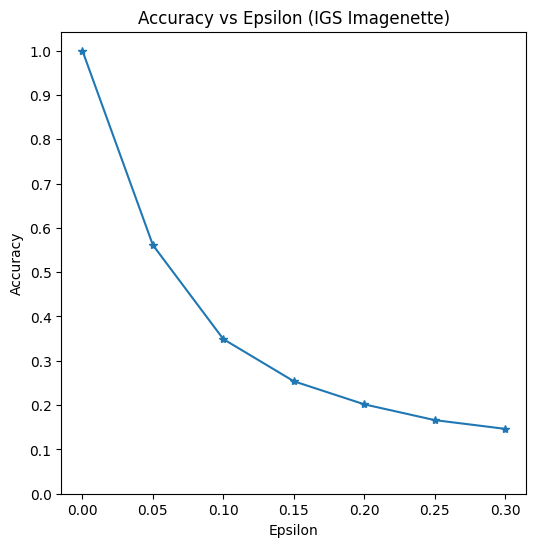

In [6]:
plt.figure(figsize=(6,6))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.35, step=0.05))
plt.title("Accuracy vs Epsilon (IGS Imagenette)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


In [7]:
imagenette_labels = ["tench", "English springer", "cassette player", "chainsaw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]

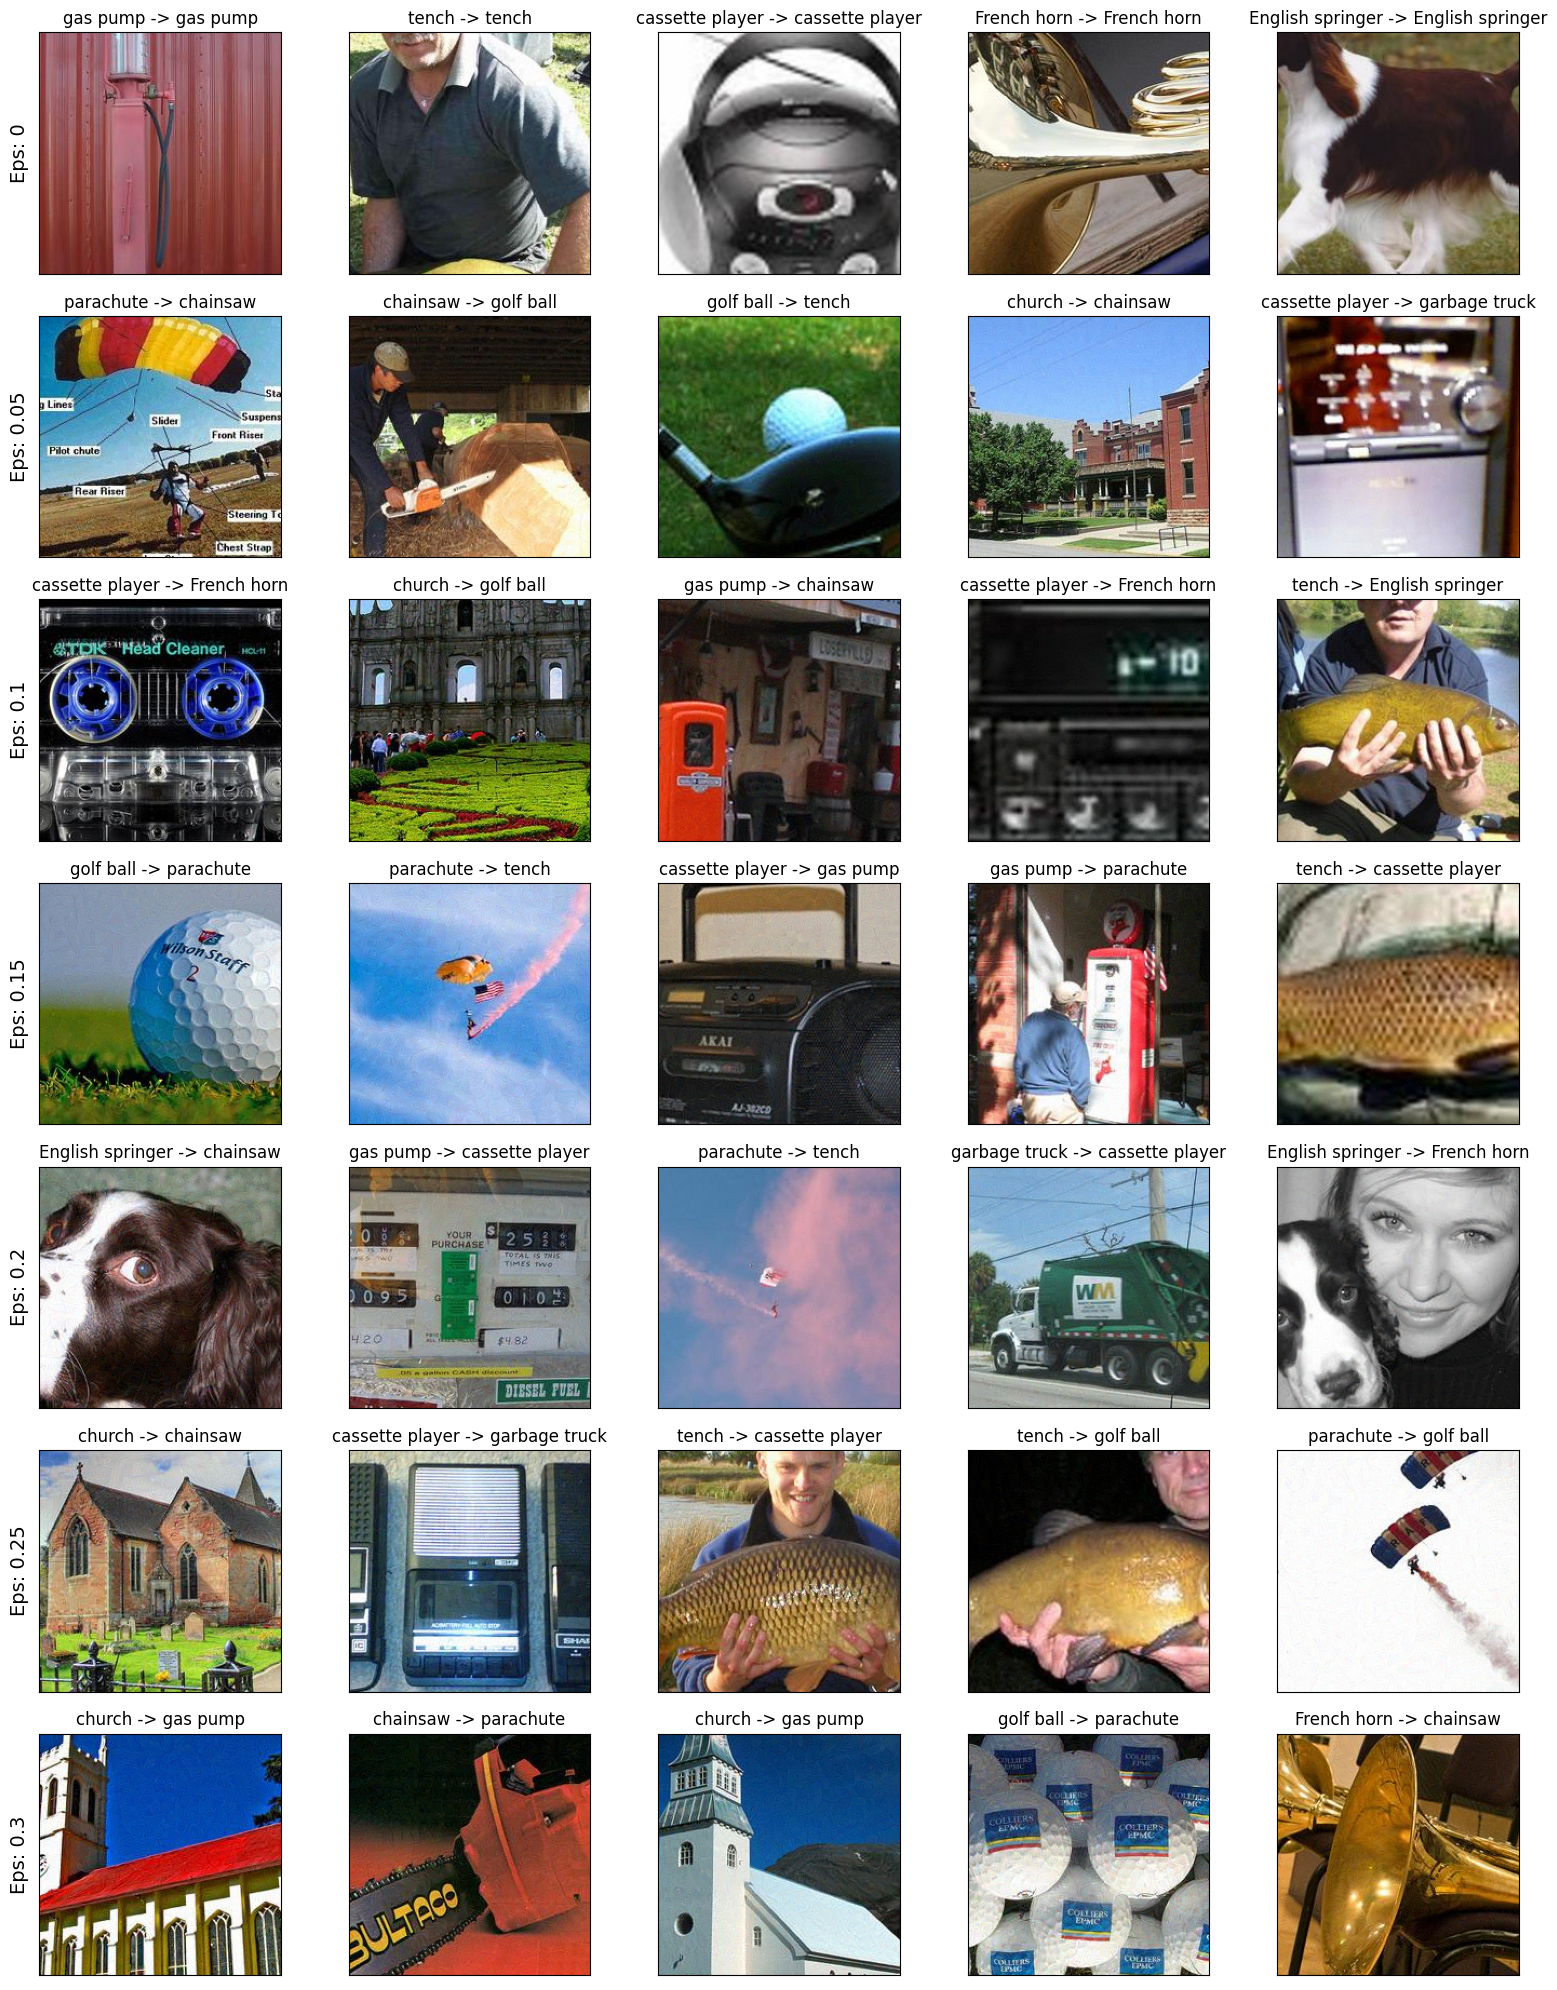

In [8]:
cnt = 0
plt.figure(figsize=(16,20))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[i]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex,_ = examples[i][j]
        plt.title("{} -> {}".format(imagenette_labels[orig], imagenette_labels[adv]))
        ex = ex.transpose(1,2,0)
        plt.imshow(ex)
plt.tight_layout()
plt.show()

## MNIST

In [3]:
# Iterative Gradient Sign attack code
def igs_attack_mnist(model, image, target, epsilon, alpha, iters): 
    
    perturbed_image = image.clone().detach()
    iters = int(min(epsilon*255 + 4, 1.25*epsilon*255)) if iters == 0 else iters # min(epsilon + 4, 1.25 * epsilon)
    
    for _ in range(iters) : 
        perturbed_image.requires_grad = True
        
        output = model(perturbed_image)
        init_pred = output.max(1, keepdim=True)[1]
        
        # If the current prediction is already wrong, dont bother to continue
        if init_pred.item() != target.item():
            return perturbed_image

        loss = F.nll_loss(output, target)  #calculate the loss

        model.zero_grad()
        loss.backward()
        data_grad = perturbed_image.grad.data

        sign_data_grad = data_grad.sign()
        perturbed_image = perturbed_image + alpha*sign_data_grad
        
                
        # Updating the image for next iteration
        perturbed_image = torch.clamp(perturbed_image, min=image - epsilon, max=image + epsilon)
        perturbed_image = torch.clamp(perturbed_image, min=0, max=1).detach()
        
    return perturbed_image

In [9]:
def test_mnist( model, device, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in tqdm(test_loader):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Call FGSM Attack
        perturbed_data = igs_attack_mnist(model, data, target, epsilon, alpha=1/255, iters=0)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


In [5]:
# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "models/lenet_mnist_model.pth"
use_cuda=True

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [10]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_mnist(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

torch.save(accuracies, 'results/igs_accuracies_mnist.pt')
torch.save(examples, 'results/igs_examples_mnist.pt')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 460.14it/s]


Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:05<00:00, 32.74it/s]


Epsilon: 0.05	Test Accuracy = 9291 / 10000 = 0.9291


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:41<00:00, 19.16it/s]


Epsilon: 0.1	Test Accuracy = 7765 / 10000 = 0.7765


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:06<00:00, 15.00it/s]


Epsilon: 0.15	Test Accuracy = 4618 / 10000 = 0.4618


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:56<00:00, 13.96it/s]


Epsilon: 0.2	Test Accuracy = 1441 / 10000 = 0.1441


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [12:02<00:00, 13.84it/s]


Epsilon: 0.25	Test Accuracy = 252 / 10000 = 0.0252


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [12:13<00:00, 13.63it/s]

Epsilon: 0.3	Test Accuracy = 13 / 10000 = 0.0013


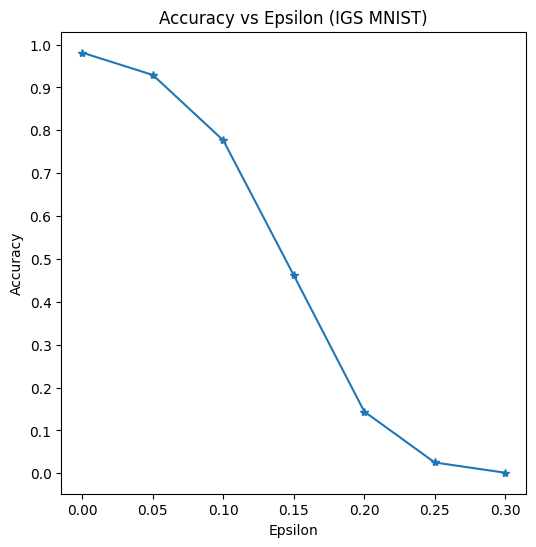

In [11]:
plt.figure(figsize=(6,6))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (IGS MNIST)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

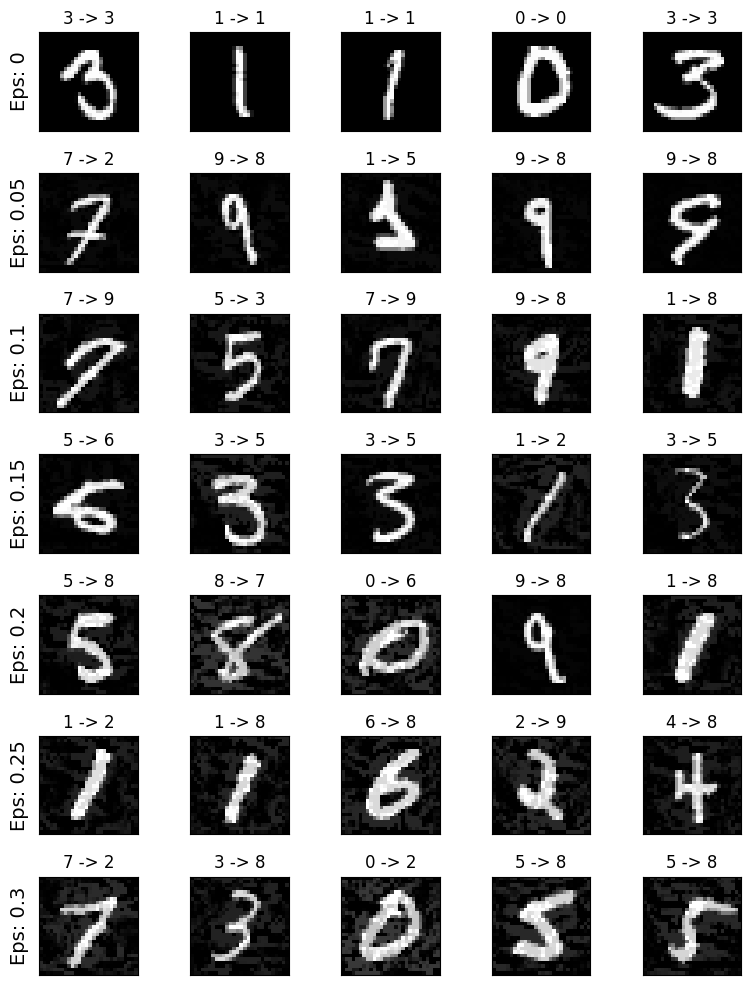

In [12]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()